<a href="https://colab.research.google.com/github/Julia891021/Artificial_Introduction_Team31/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install efficientnet_pytorch
!pip install torchvision
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=6df403021dddd75b2e7a27215ccd9e3454165c869d913d1779bf21a3855c3de0
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 串接雲端硬碟

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/Shareddrives/AI_Team31')

Mounted at /content/drive


### Import Library

In [ ]:
# Check data directory
os.listdir("FaceShape Dataset")

['desktop.ini', 'testing_set', 'training_set']

### Split train, val 

In [ ]:
def split_train_val(data_dir, val_size=0.1, random_state=42):
    train, test = [], []
    for dset in os.listdir(data_dir):
        # check is directory
        subdir = os.path.join(data_dir, dset)
        if os.path.isdir(subdir):
            for label in os.listdir(subdir):
                imgdir = os.path.join(subdir, label)
                if os.path.isdir(imgdir):
                    for image_path in os.listdir(imgdir):
                        if image_path.endswith(".jpg"):
                            sample = {
                                "path": os.path.join(subdir, label, image_path),
                                "label": label
                            }
                            if dset == "training_set":
                                train.append(sample)
                            elif dset == "testing_set":
                                test.append(sample)
    
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    train, val = train_test_split(train, test_size=val_size, random_state=random_state)
    # save to csv
#     train_path, val_path, test_path = os.path.join(data_dir, "train.csv"), os.path.join(data_dir, "val.csv"), os.path.join(data_dir, "test.csv")
#     train.to_csv(train_path, index=False)
#     val.to_csv(val_path, index=False)
#     test.to_csv(test_path, index=False)
    
    return train, val, test

train_df, val_df, test_df = split_train_val("FaceShape Dataset")
test_df

,path,label
0,FaceShape Dataset/testing_set/Oblong/oblong (2...,Oblong
1,FaceShape Dataset/testing_set/Oblong/oblong (1...,Oblong
2,FaceShape Dataset/testing_set/Oblong/oblong (3...,Oblong
3,FaceShape Dataset/testing_set/Oblong/oblong (1...,Oblong
4,FaceShape Dataset/testing_set/Oblong/oblong (1...,Oblong
...,...,...
1008,FaceShape Dataset/testing_set/Heart/heart (726...,Heart
1009,FaceShape Dataset/testing_set/Heart/heart (453...,Heart
1010,FaceShape Dataset/testing_set/Heart/heart (455...,Heart
1011,FaceShape Dataset/testing_set/Heart/heart (603...,Heart


### Visualize some images and labels

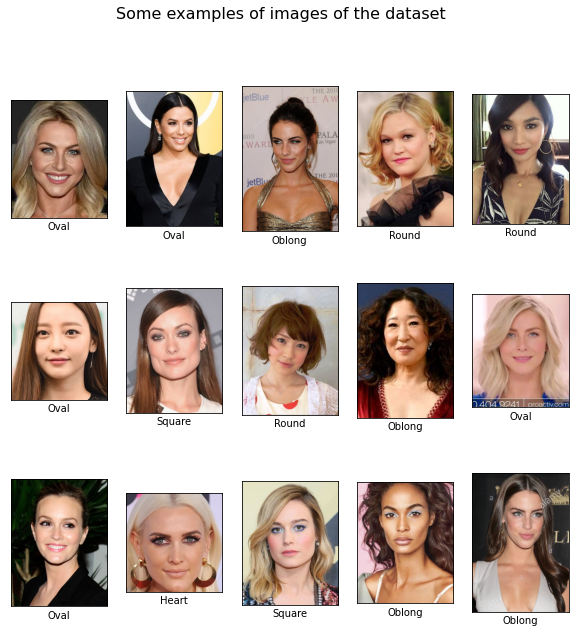

In [ ]:
import cv2
import matplotlib.pyplot as plt  

def display_examples():
    
    """
        Display 15 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(15):
        plt.subplot(3,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = train_df.iloc[i]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(train_df.iloc[i]["label"])
    plt.show()

display_examples()


### Dataset

In [ ]:
# Dataset
class FaceShapeDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, split="train"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.split = split
        class_names = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']
        self.label2idx = {class_name:i for i, class_name in enumerate(class_names)}
        self.idx2label = {v:k for k,v in self.label2idx.items()}
    
    def __len__(self):
        return len(self.df)

   
    def __getitem__(self, idx):
        try:
            img_path = self.df.loc[idx, "path"]
            img = Image.open(img_path).convert('L')
            if self.transform:
                img = self.transform(img)
            
            label = self.df.loc[idx, "label"]
            label = self.label2idx[label]
            return img, torch.tensor(label)
        except:
            print(f"Error load image {img_path}")
            idx = 0
            img_path = self.df.loc[idx, "path"]
            img = Image.open(img_path).convert('L')
            if self.transform:
                img = self.transform(img)
            
            label = self.df.loc[idx, "label"]
            label = self.label2idx[label]
            return img, torch.tensor(label)

### EfficientNet

In [ ]:
# Models
class EffNet(nn.Module):
    def __init__(self, num_classes=5):
        super(EffNet, self).__init__()
        self.eff = EfficientNet.from_pretrained('efficientnet-b5', num_classes=num_classes, in_channels=1)
    def forward(self, x):
        x = self.eff(x)
        return x

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    best_accuracy = 0
    for epoch in range(epochs):
        model.train()
        bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Epoch {}".format(epoch+1))
        for batch_idx, (data, target) in bar:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            bar.set_postfix(loss=loss.item())
        
        
        model.eval()
        val_loss = 0
        correct = 0
        
        with torch.no_grad():
            bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation Epoch {}".format(epoch+1))
            for batch_idx, (data, target) in bar:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100. * correct / len(val_loader.dataset)
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            val_accuracy))
        
        # save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "./best_model1.pth")
            print("Saved best model")
        print("Best accuracy: {}".format(best_accuracy))

    return model

In [ ]:
# Configs
class args:
    data_dir="FaceShape Dataset"
    batch_size=10
    n_epochs=20
    learning_rate=0.001
    debug=False

In [ ]:
train_df, val_df, test_df = split_train_val(args.data_dir)
if args.debug:
    train_df, val_df = train_df.sample(n=10).reset_index(drop=True), val_df.sample(n=10).reset_index(drop=True)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_loader = torch.utils.data.DataLoader(
    FaceShapeDataset(train_df, transform=transform, split="train"),
    batch_size=args.batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    FaceShapeDataset(val_df, transform=transform, split="val"),
    batch_size=args.batch_size, shuffle=False
)

### Start Training



In [ ]:
# import time
# from datetime import timedelta
# st = time.time()
# print("-------- Start training --------")
# model = EffNet().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
# model = train(model, train_loader, val_loader, criterion, optimizer, epochs=args.n_epochs, device=device)
# print("-------- End training, time taken:", timedelta(seconds=int(time.time()-st)))

### Load Pretrined model

In [ ]:
path = '/content/drive/Shareddrives/AI_Team31/best_model.pth'
model = EffNet().to(device)
model.load_state_dict(torch.load(path))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b5


<All keys matched successfully>

### Predict on test set

In [ ]:
test_ds = FaceShapeDataset(test_df, transform=transform, split="test")
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=args.batch_size, shuffle=False
)
model.eval()
test_loss = 0
correct = 0
y_true = []
y_pred = []
prob_list = []
with torch.no_grad():
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.cross_entropy(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
      y_true += target.view(-1).tolist()
      y_pred += pred.view(-1).tolist()
        
test_loss /= len(test_loader.dataset)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

y_true = [test_ds.idx2label[i] for i in y_true]
y_pred = [test_ds.idx2label[i] for i in y_pred]
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


Test set: Average loss: 1.0085, Accuracy: 766/1013 (76%)

              precision    recall  f1-score   support

       Heart       0.76      0.69      0.72       201
      Oblong       0.81      0.80      0.81       202
        Oval       0.62      0.68      0.65       208
       Round       0.72      0.82      0.77       202
      Square       0.90      0.80      0.85       200

    accuracy                           0.76      1013
   macro avg       0.76      0.76      0.76      1013
weighted avg       0.76      0.76      0.76      1013



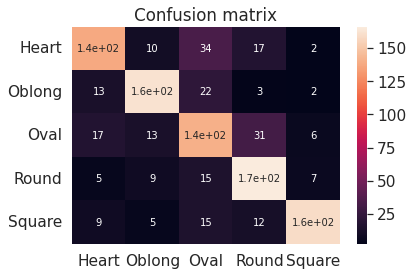

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)

CM = confusion_matrix(y_true, y_pred)
class_names = list(test_ds.label2idx.keys())
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

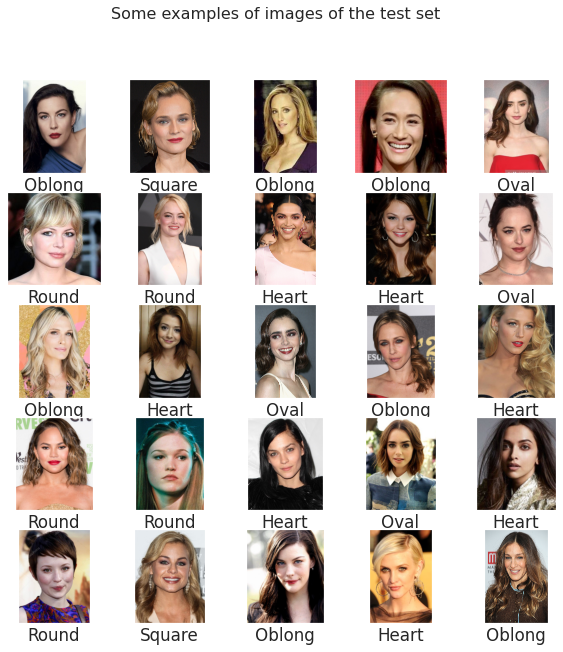

In [ ]:
import cv2
import matplotlib.pyplot as plt
from random import randint

list_idx = [randint(0, len(test_ds)) for i in range(25)]

def display_examples():
    
    """
        Display 25 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the test set", fontsize=16)
    for i,idx in enumerate(list_idx):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = test_ds.df.iloc[idx]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(y_true[idx])
    plt.show()

display_examples()


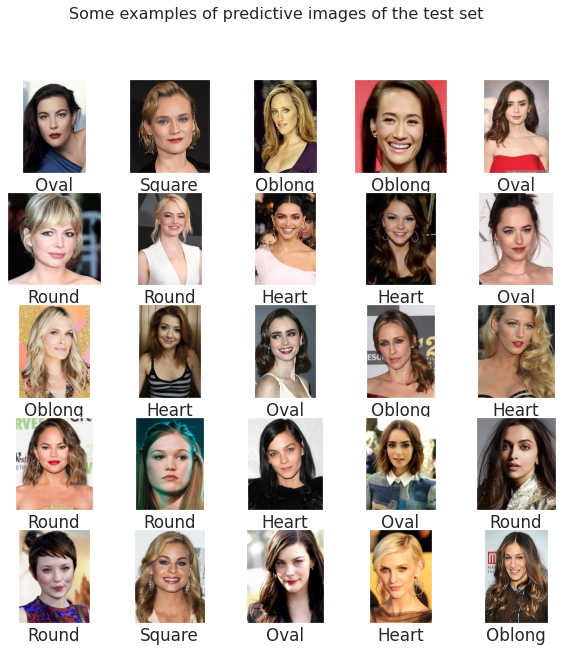

In [ ]:
def display_examples():
    
    """
        Display 25 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of predictive images of the test set", fontsize=16)
    for i,idx in enumerate(list_idx):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = test_ds.df.iloc[idx]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(y_pred[idx])
    plt.show()

display_examples()

### 圖片預測臉型，比對相同臉型長相最相似前3名，推薦髮型

In [ ]:
!pip install face_recognition
import os
import face_recognition
from PIL import Image, ImageDraw
import torchvision.transforms as T

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 36 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=e77b397a1ab6ac87c8875b13e495aea77c3c822c25f422aad652809589ea8ee1
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
def get_Remove_BG(img_path,y_pred):
  img_bgr = cv2.imread(img_path)
  img_rgb = img_bgr[:, :, [2, 1, 0]]   #BGR轉RGB
  known_image = img_rgb
  # 已知人臉位置的臉部編碼
  face_locations = face_recognition.face_locations(known_image, number_of_times_to_upsample=1, model="cnn")
  print("照片共辨識出 {} 張臉。".format(len(face_locations)))
  #print(face_locations[0])
  known_image_encodings = face_recognition.face_encodings(known_image, known_face_locations=face_locations, num_jitters=10)[0]
  print("照片共產生 {} 組特徵值。".format(len(known_image_encodings)))
  # 相同臉型人臉位置的臉部編碼(Hair Sample)
  new_image_path_list=[]
  dataPath = os.getcwd()+"/Hair_Sample/" + y_pred
  foldername = os.listdir(dataPath)
  for folder in foldername:
    new_image_path_list.append(os.path.join(dataPath,folder))
  euclidean_distance_list=[]  
  for i in range(len(new_image_path_list)):
    new_image_path = new_image_path_list[i]
    new_image = face_recognition.load_image_file(new_image_path,mode = 'RGB')
    new_image_encoding = face_recognition.face_encodings(new_image)[0]
    # 進行計算並顯示結果
    euclidean_distance = face_recognition.face_distance([known_image_encodings], new_image_encoding)
    euclidean_distance_list.append(euclidean_distance)
  print(euclidean_distance_list)
  euclidean_distance_list_copy = euclidean_distance_list.copy()
  euclidean_distance_list_copy.sort()  #小到大
  index=[]
  for i in range(3):  #取distance前三小的
    index.append(euclidean_distance_list.index(euclidean_distance_list_copy[i][0])+1)
  result=[]
  for i in range(len(index)):
    # Remove_BG = os.getcwd()+"/Hair_Sample/Remove_BG/" + y_pred + "/" + y_pred + str(index[i])+".png"
    Remove_BG = os.getcwd()+"/Hair_Sample/" + y_pred + "/" + y_pred +str(index[i])+".jpeg"
    Remove_BG_BGR = cv2.imread(Remove_BG)
    result.append(Remove_BG_BGR) 
  return img_bgr,result

index:  620
Round
照片共辨識出 1 張臉。
照片共產生 128 組特徵值。
[array([0.76459459]), array([0.78267206]), array([0.91543581]), array([0.84564483]), array([0.31183042]), array([0.75747183]), array([0.77942614]), array([0.82922142]), array([0.82762955]), array([0.75242976]), array([0.89119972]), array([0.75206673]), array([0.79960983]), array([0.8508843]), array([0.32720353]), array([0.63213615]), array([0.78391543]), array([0.74686266]), array([0.78547116]), array([0.82122061]), array([0.72714509])]


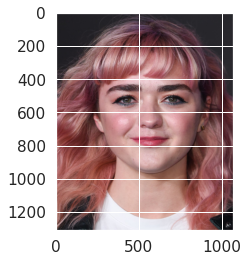

In [ ]:
for i in range(test_df.shape[0]):
  if test_df['path'][i] == 'FaceShape Dataset/testing_set/Round/round (15).jpg':
    index=i
    print('index: ',i)
print(y_pred[index])
os.chdir('/content/drive/Shareddrives/AI_Team31')
pic,hair=get_Remove_BG(test_df['path'][index], y_pred[index])
plt.imshow(pic[:, :, [2, 1, 0]] )
# pic.shape
# plt.imshow(hair[1])

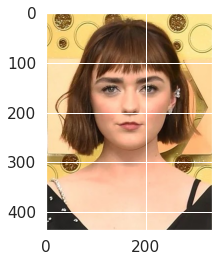

In [ ]:
plt.imshow(hair[0][:, :, [2, 1, 0]])

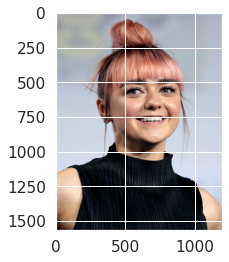

In [ ]:
plt.imshow(hair[1][:, :, [2, 1, 0]])

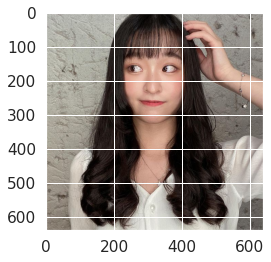

In [ ]:
plt.imshow(hair[2][:, :, [2, 1, 0]])

In [ ]:
os.chdir('/content/drive/Shareddrives/AI_Team31/Barbershop-main/unprocessed')
cv2.imwrite('original_pic_'+str(index)+'.jpeg', pic)
for i in range(len(hair)):
  cv2.imwrite('hair'+str(i)+'_'+str(index)+'.jpeg', hair[i])

In [ ]:
import os
os.chdir('/content/drive/Shareddrives/AI_Team31/Barbershop-main')

In [ ]:
!pip install Ninja
!python align_face.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 4.3 MB/s 
hair2_220.jpeg: Number of faces detected: 1
hair1_220.jpeg: Number of faces detected: 1
hair0_220.jpeg: Number of faces detected: 1
original_pic_220.jpeg: Number of faces detected: 1
90.jpg: Number of faces detected: 1
hair2_606.jpeg: Number of faces detected: 1
hair0_602.jpeg: Number of faces detected: 1
hair1_602.jpeg: Number of faces detected: 1
hair2_602.jpeg: Number of faces detected: 1
hair0_609.jpeg: Number of faces detected: 1
hair1_609.jpeg: Number of faces detected: 1
hair2_609.jpeg: Number of faces detected: 1
hair1_608.jpeg: Number of faces detected: 1
hair0_608.jpeg: Number of faces detected: 1
hair2_608.jpeg: Number of faces detected: 1
original_pic_620.jpeg: Number of faces detected: 1
hair1_620.jpeg: Number of faces detected: 1
hair2_620.jpeg: Number of faces detected: 1
hair0_620.jpeg: Number of faces detected: 1


In [ ]:
!python main.py --im_path1 original_pic_620.png --im_path2 hair0_620.png --im_path3 hair0_620.png --sign realistic --smooth 5

Loading StyleGAN2 from checkpoint: pretrained_models/ffhq.pt
Setting up Perceptual loss...
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:03<00:00, 156MB/s]
Loading model from: /content/drive/Shareddrives/AI_Team31/Barbershop-main/losses/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done
Number of images: 2
Images:   0% 0/2 [00:00<?, ?it/s]
Embedding:   0% 0/1100 [00:00<?, ?it/s]
Embedding:   0% 1/1100 [00:00<07:33,  2.43it/s]
Embedding:   0% 2/1100 [00:00<05:42,  3.21it/s]
Embedding:   0% 3/1100 [00:00<05:14,  3.49it/s]
Embedding:   0% 4/1100 [00:01<05:04,  3.60it/s]
Embedding:   0% 5/1100 [00:01<05:05,  3.58it/s]
Embedding:   1% 6/1100 [00:01<04:58,  3.66it/s]
Embedding:   1% 7/1100 [00:01<04:53,  3.72it/s]
Embedding:   1% 8/1100 [00:02<04:50,  3.75it/s]
Embedding:   1% 9/1100 [00:02<04:52,  3.73it/s]
Embedding:   1% 10/1100 [00:02<04:50,  3.75it/s]
Embedding:   1% 11/110

In [ ]:
!python main.py --im_path1 original_pic_620.png --im_path2 hair1_620.png --im_path3 hair1_620.png --sign realistic --smooth 5

Loading StyleGAN2 from checkpoint: pretrained_models/ffhq.pt
Setting up Perceptual loss...
Loading model from: /content/drive/Shareddrives/AI_Team31/Barbershop-main/losses/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done
Number of images: 2
Images:   0% 0/2 [00:00<?, ?it/s]
Embedding:   0% 0/1100 [00:00<?, ?it/s]
Embedding:   0% 1/1100 [00:00<04:20,  4.22it/s]
Embedding:   0% 2/1100 [00:00<04:51,  3.76it/s]
Embedding:   0% 3/1100 [00:00<04:50,  3.77it/s]
Embedding:   0% 4/1100 [00:01<04:49,  3.79it/s]
Embedding:   0% 5/1100 [00:01<04:49,  3.78it/s]
Embedding:   1% 6/1100 [00:01<04:52,  3.74it/s]
Embedding:   1% 7/1100 [00:01<04:51,  3.75it/s]
Embedding:   1% 8/1100 [00:02<04:51,  3.75it/s]
Embedding:   1% 9/1100 [00:02<04:52,  3.73it/s]
Embedding:   1% 10/1100 [00:02<04:52,  3.73it/s]
Embedding:   1% 11/1100 [00:02<04:52,  3.72it/s]
Embedding:   1% 12/1100 [00:03<04:51,  3.73it/s]
Embedding:   1% 13/1100 [00:03<04:52,  3.71it/s]
Embedding:   1% 14/1100 [00:03<04:52,  3

In [ ]:
!python main.py --im_path1 original_pic_620.png --im_path2 hair2_620.png --im_path3 hair2_620.png --sign realistic --smooth 5

Loading StyleGAN2 from checkpoint: pretrained_models/ffhq.pt
Setting up Perceptual loss...
Loading model from: /content/drive/Shareddrives/AI_Team31/Barbershop-main/losses/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done
Number of images: 2
Images:   0% 0/2 [00:00<?, ?it/s]
Embedding:   0% 0/1100 [00:00<?, ?it/s]
Embedding:   0% 1/1100 [00:00<04:55,  3.71it/s]
Embedding:   0% 2/1100 [00:00<05:04,  3.60it/s]
Embedding:   0% 3/1100 [00:00<04:52,  3.75it/s]
Embedding:   0% 4/1100 [00:01<04:49,  3.78it/s]
Embedding:   0% 5/1100 [00:01<04:52,  3.75it/s]
Embedding:   1% 6/1100 [00:01<04:48,  3.79it/s]
Embedding:   1% 7/1100 [00:01<04:48,  3.79it/s]
Embedding:   1% 8/1100 [00:02<04:48,  3.79it/s]
Embedding:   1% 9/1100 [00:02<04:47,  3.80it/s]
Embedding:   1% 10/1100 [00:02<04:48,  3.78it/s]
Embedding:   1% 11/1100 [00:02<04:47,  3.79it/s]
Embedding:   1% 12/1100 [00:03<04:47,  3.78it/s]
Embedding:   1% 13/1100 [00:03<04:48,  3.77it/s]
Embedding:   1% 14/1100 [00:03<04:45,  3

In [ ]:
os.chdir('/content/drive/Shareddrives/AI_Team31/Barbershop-main/output')
image1 = '/content/drive/Shareddrives/AI_Team31/Barbershop-main/output/original_pic_620_hair0_620_hair0_620_realistic.png'
image2 = '/content/drive/Shareddrives/AI_Team31/Barbershop-main/output/original_pic_620_hair1_620_hair1_620_realistic.png'
image3 = '/content/drive/Shareddrives/AI_Team31/Barbershop-main/output/original_pic_620_hair2_620_hair2_620_realistic.png'

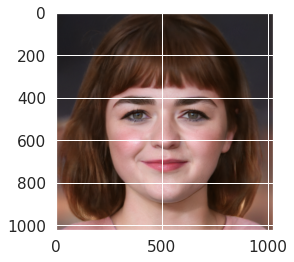

In [ ]:
image = cv2.imread(image1)
plt.imshow(image[:, :, [2, 1, 0]])

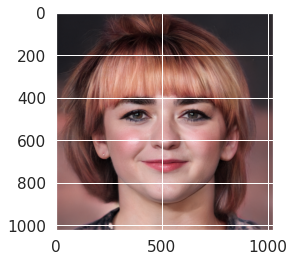

In [ ]:
image = cv2.imread(image2)
plt.imshow(image[:, :, [2, 1, 0]])

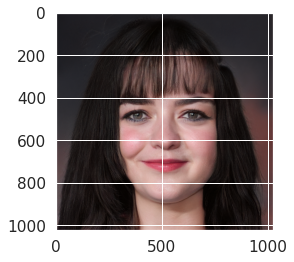

In [ ]:
image = cv2.imread(image3)
plt.imshow(image[:, :, [2, 1, 0]])

In [ ]:
os.chdir('/content/drive/Shareddrives/AI_Team31')
!pip install pipreqs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pipreqs ./

INFO: Successfully saved requirements file in ./requirements.txt
